# Quick start

This tutorial shows you how to handle single and multi-resolution maps (a.k.a. [multi-order coverage](http://ivoa.net/documents/MOC) maps or MOC maps). It assumes previous knowledge of [HEALPix](https://healpix.jpl.nasa.gov/). If you already are a [healpy](https://healpy.readthedocs.io/) user, it should be straightforward to start using *mhealpy*.

See also the [API](../api/index.rst) documentation, as this is not meant to be exhaustuve.

## _mhealpy_ as an object-oriented _healpy_ wrapper

A single-resolution map is completely defined by an order ($npix = 12 * 4^{order} = 12 * nside^2$), a scheme (_RING_ or _NESTED_) and an list of the maps contents. In _healpy_ there is no class that contains this information, but rather the user needs to keep track of these and pass this information around to various functions. For example, to fill a map you can do:

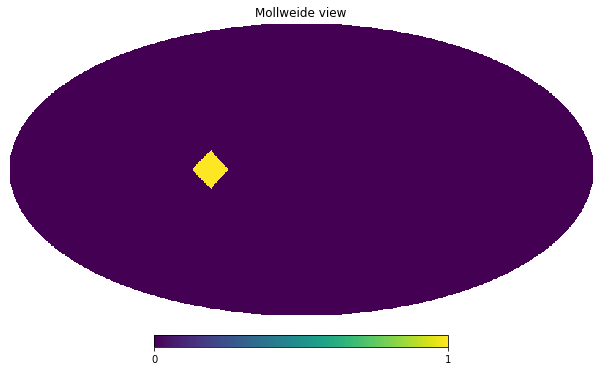

In [1]:
import numpy as np
import healpy as hp

# Define the grid
nside = 4
scheme = 'nested'
is_nested = (scheme == 'nested')

# Initialize the "map", which is a simple array
data = np.zeros(hp.nside2npix(nside))

# Get the pixel where a point lands in the current scheme
theta = np.deg2rad(90)
phi = np.deg2rad(50)

sample_pix = hp.ang2pix(nside, theta, phi, nest = is_nested)

# Add the count
data[sample_pix] += 1

# Save to disc
hp.write_map("my_map.fits", data, nest = is_nested, overwrite=True, dtype = int)

# Plot
hp.mollview(data, nest = is_nested)

At zeroth-order, [HealpixMap](../api/classes.rst#healpixmap) is a container that keeps track of the information defining the grid. The equivalent code would look like:

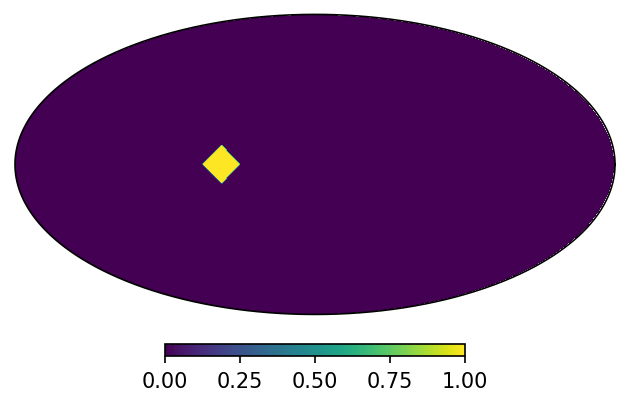

In [2]:
from mhealpy import HealpixMap

# Define the grid and initialize
m = HealpixMap(nside = nside, scheme = scheme, dtype = int)

# Get the pixel where a point lands in the current scheme
sample_pix = m.ang2pix(theta, phi)

# Add the count
m[sample_pix] += 1

# Save to disc
m.write_map("my_map.fits", overwrite=True)

# Plot
m.plot();

[HealpixMap](../api/classes.rst#healpixmap) objects are array-like, which mean you can cast them into a _numpy_ _array_, do slicing and indexing, iterate over them and use built-in functions. For example:

In [3]:
data = np.array(m)

print("Data: {}".format(data))

print("Max: {}".format(max(m)))

for pix,content in enumerate(m):
    if content > 0:
        print("Max center: {} deg".format(np.rad2deg(m.pix2ang(pix))))

Data: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
Max: 1
Max center: [90.   56.25] deg


## Plotting

_healpy_ contains multiple routines to plot maps with various projections, and add text, points and graticules. For example, we can do a zoom in the previous map with:

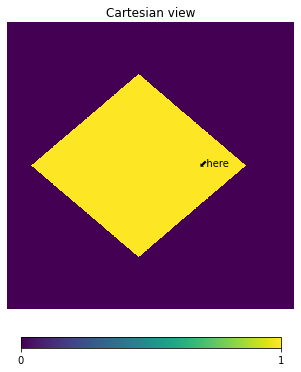

In [4]:
hp.cartview(data, nest = is_nested, latra = [-15,15], lonra = [40,70])

hp.projtext(theta, phi, "⬋here");

[HealpixMap](../api/classes.rst#healpixmap) has a single [plot()](../api/classes.rst#mhealpy.HealpixMap.plot) method, but it is more versatile. It plots into an astropy [WCSAxes](https://docs.astropy.org/en/stable/visualization/wcsaxes/index.html), a type of _matplotlib_ [Axes](https://matplotlib.org/api/axes_api.html), which allows full control over how and where to plot the map, and to use the native methods such as plot(), scatter() and text(). While you can use any WCSAxes you want, `mhealpy` includes various custom axes that take similar parameters to `healpy`'s visualization methods. For example:

Text(50.0, 0.0, '⬋here')

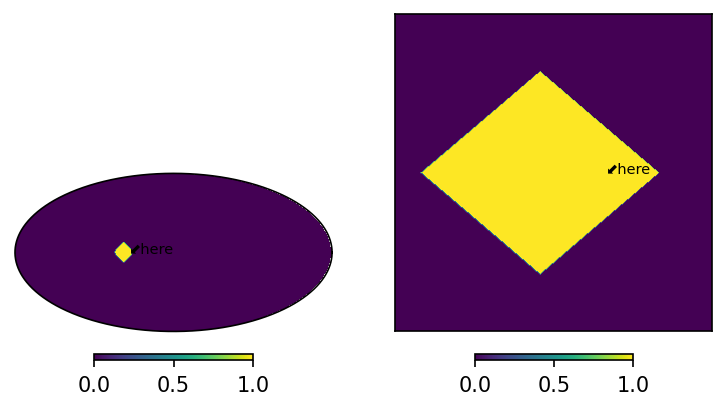

In [5]:
import matplotlib.pyplot as plt

# Create custom axes
fig = plt.figure(dpi = 150)

axMoll = fig.add_subplot(1,2,1, projection = 'mollview')
axCart = fig.add_subplot(1,2,2, projection = 'cartview', latra = [-15,15], lonra = [40,70])

# Plot in one of the axes
plotMoll, projMoll = m.plot(ax = axMoll)
plotCart, projCart = m.plot(ax = axCart)

# Use the projector to get the equivalent plot pixel for a given coordinate
# You can use it with any matplotlib method
lon = np.rad2deg(phi)
lat = 90 - np.rad2deg(theta)
axMoll.text(lon, lat, "⬋here", size = 7, transform = axMoll.get_transform('world'))
axCart.text(lon, lat, "⬋here", size = 7, transform = axCart.get_transform('world'))

## Order/scheme changes and the _density_ parameter

In _healpy_ you can change the underlaying grid of a map with a combination of [ud_grade()](https://healpy.readthedocs.io/en/latest/generated/healpy.pixelfunc.ud_grade.html), [reorder()](https://healpy.readthedocs.io/en/latest/generated/healpy.pixelfunc.reorder.html). The equivalent in a _HealpixMap_ is to use [rasterize()](../api/classes.rst#mhealpy.HealpixMap.rasterize), e.g.:

In [6]:
# Upgrade from nside = 4 to nside = 8, and change scheme from 'nested' to 'ring'
m_up = m.rasterize(8, scheme = 'ring')

print("New nside: {}".format(m_up.nside))
print("New scheme: {}".format(m_up.scheme))
print("New max: {}".format(max(m_up)))
print("New total: {}".format(sum(m_up)))

New nside: 8
New scheme: RING
New max: 0.25
New total: 1.0


In the original map we had one single count, so the maximum was 1. When we upgraded the resolution, the maximum of the new map is 0.25 but the total is still 1. This happened because, by default, the map are considered histograms and the value of new pixels is updated when they are split or combined. In this case, a pixel with a value of 1 was split into 4 child pixels, each with a value of 0.25.

This behaviour can be changed with the `density` parameter. If `True`, the value of each pixels is considered to be the evaluation of a function at the center of the pixel. Or equivalently, the map is considered a histogram whose contents have been divided by the area of the pixel, resulting in a density distribution. 

In [7]:
m.density(True)

# Change grid
m_up = m.rasterize(8, scheme = 'ring')

print("New nside: {}".format(m_up.nside))
print("New scheme: {}".format(m_up.scheme))
print("New max: {}".format(max(m_up)))
print("New total: {}".format(sum(m_up)))

New nside: 8
New scheme: RING
New max: 1.0
New total: 4.0


The maximum now stays a constant 1, but the total count is no longer conserved. We now have 4 pixels with the same value as the parent pixel.

## Arithmethic operations

Regardless of the underlaying grid, you can operate on maps pixel-wise using ``*``, ``/``, ``+``, ``-``, ``**``, ``==`` and ``abs``. To illustrate this let's multiply two simple maps:

Result nside: 128
Result scheme: NESTED


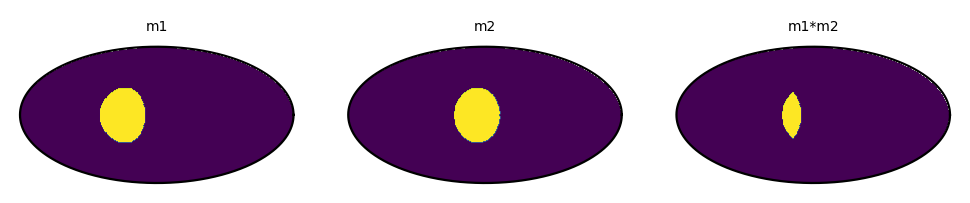

In [8]:
import mhealpy as hmap

# Initialize map. 
# Note this are density maps. This parameters comes into play when operatiing over two
# maps with different NSIDE
# If both maps are density-like, the result is also density-like,
# otherwise the result is histogram-like
m1 = HealpixMap(nside = 64, scheme = 'ring', density = True)
m2 = HealpixMap(nside = 128, scheme = 'nested', density = True)

# Fill first map with a simple disc
theta = np.deg2rad(90)
phi = np.deg2rad(45)
radius = np.deg2rad(30)
disc_pix = m1.query_disc(hmap.ang2vec(theta, phi), radius)

m1[disc_pix] = 1

# Fill second map with a similar disc, just shifted
phi = np.deg2rad(10)
disc_pix = m2.query_disc(hmap.ang2vec(theta, phi), radius)

m2[disc_pix] = 1

# Multiply
mRes = m1*m2

print("Result nside: {}".format(mRes.nside))
print("Result scheme: {}".format(mRes.scheme))

# Plot side by side
fig,(ax1,ax2,axRes) = plt.subplots(1,3, dpi=200, subplot_kw = {'projection': 'mollview'})

ax1.set_title("m1", size= 5);
ax2.set_title("m2", size= 5);
axRes.set_title("m1*m2", size= 5);

m1.plot(ax1, cbar = None)
m2.plot(ax2, cbar = None)
mRes.plot(axRes, cbar = None);

The resulting map of binary operation always has the finest grid of the two inputs. This ensures there is no loss of information. If both maps have the same _nside_, the output map has the scheme of the left operarand.

Sometimes though you want to keep the grid of a specific map. For that you can use in-place operations. If you really need a new map, you can use in-place operations in combination with `deepcopy`. For example:

Result nside: 64
Result scheme: RING


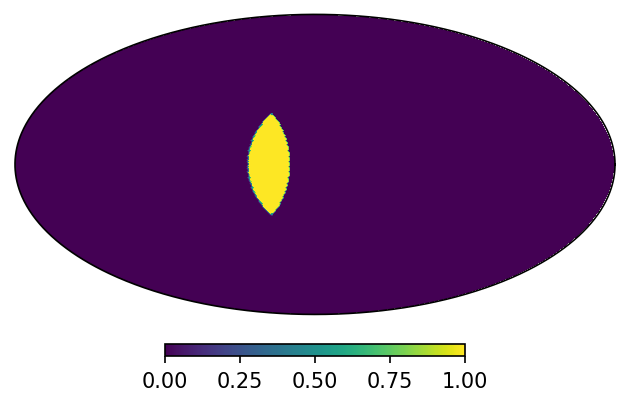

In [9]:
from copy import deepcopy

mRes = deepcopy(m1)

mRes *= m2

print("Result nside: {}".format(mRes.nside))
print("Result scheme: {}".format(mRes.scheme))

mRes.plot();

## Multi-resolution maps

[Multi-order coverage](http://ivoa.net/documents/MOC/) (MOC) map --i.e. multi-resolution maps-- are maps that tile the sky using pixels corresponding to different _nside_. Because a simple pixel number correspond to different locations depending on the map order, each pixel that composes the map needs to know the corresponding _nside_. Instead of storing two numbera though, we use the _NUNIQ_ scheme, where each pixels is labeled by an _uniq_ number defined as:

$$
uniq = 4 * nside * nside + ipix , 
$$

where $ipix$ corresponds to the pixel number in a _NESTED_ scheme. This operation can be easily reversed to obtain both the _nside_ and _ipix_ values.

As a first example, let's assign to the 12 base pixels of a zero-order map the values of their own indices, but splitting the first pixel into the four child pixels of the nest order:

In [10]:
#           child pixels of ipix=0 | rest of the base pixels
uniq     = [16, 17, 18, 19,          5, 6, 7, 8,  9, 10, 11, 12, 13, 14, 15]
contents = [0,   0,  0,  0,          1, 2, 3, 4,  5,  6,  7,  8,  9, 10, 11]

m = HealpixMap(contents, uniq, density = True)

If you plot it, it'll look as a single-resolution map:

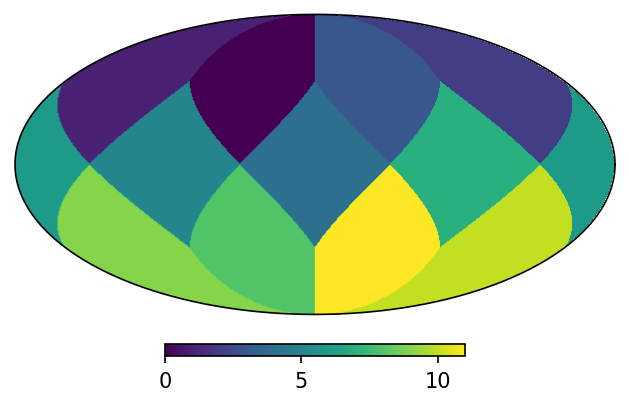

In [11]:
m.plot();

But if we plot the pixel boundaries it'll be clear that his is a multi-resolution map:

Is this a multi-resolution map? True


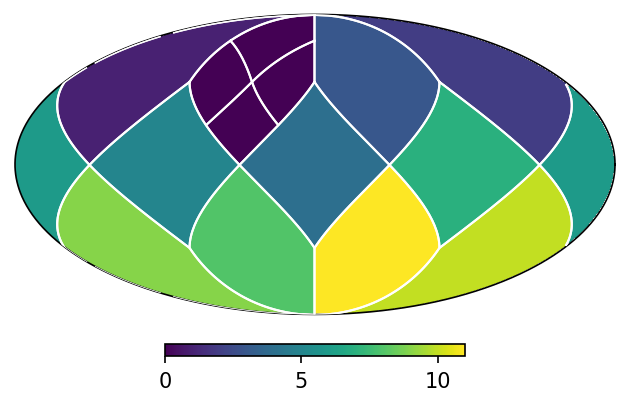

In [12]:
print("Is this a multi-resolution map? {}".format(m.is_moc))
    
m.plot()
m.plot_grid(ax = plt.gca(), color = 'white', linewidth = 1);

If you initialize the data of a MOC map by hand, it's generally a good idea to check that all locations of the sphere are covered by one and only one pixel:

In [13]:
m.is_mesh_valid()

True

### Adaptive grids

Usually though, you don't need to create the grid of a MOC map by hand since _mhealpy_ can choose an appropiate pixelation for you. The simplest case is when you know exactly which region needs a higher pixelation. For example, assume there is a source localized to a ~0.01deg reosolution. In order to achieve this resolution, you need a map with an _nside_ of 16384 (the pixel size is ~0.003deg). It would be wasteful to hold in memory a full map for only this region of the sky. 

NUNIQ pixels in MOC map: 372
Equivalent single-resolution pixels: 3221225472


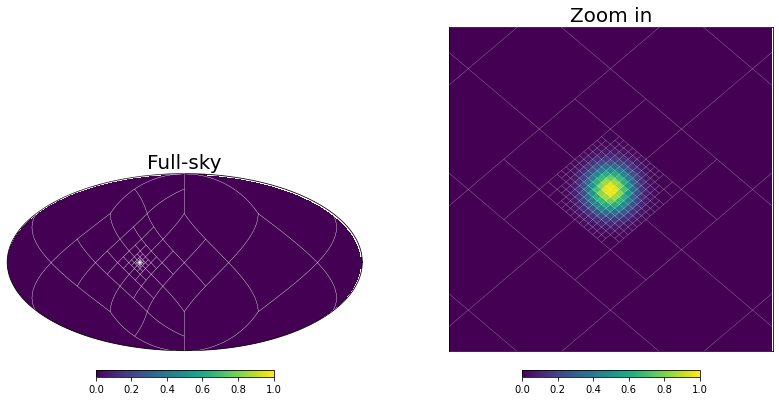

In [14]:
from numpy import exp
from mhealpy import HealpixBase

# Location and uncertainty of the source
theta0 = np.deg2rad(90)
phi0 = np.deg2rad(45)
sigma = np.deg2rad(0.01)

# Chose an appropiate nside to represent it
# HealpixBase is a map without data, only the grid is defined
mEq = HealpixBase(order = 14)

# Create a MOC map where the region around the source is
# finely pixelated at the highest order, and the rest of
# the map is left to mhealpy to fill appropiately
disc_pix = mEq.query_disc(hmap.ang2vec(theta0, phi0), 3*sigma)

m = HealpixMap.moc_from_pixels(mEq.nside, disc_pix, density=True)

print("NUNIQ pixels in MOC map: {}".format(m.npix))
print("Equivalent single-resolution pixels: {}".format(mEq.npix))

# Fill the map. This code would look exactly the same if this were a 
# single-resolution map
for pix in range(m.npix):
    
    theta,phi = m.pix2ang(pix)
    
    m[pix] = exp(-((theta-theta0)**2 + (phi-phi0)**2) / 2 / sigma**2)
    
# Plot, zooming in around the source
fig = plt.figure(figsize = [14,7])

lonra = np.rad2deg(phi0) + [-.1, .1]
latra = 90 - np.rad2deg(theta0) + [-.1, .1]

axMoll = fig.add_subplot(1,2,1, projection = "mollview")
axCart = fig.add_subplot(1,2,2, projection = "cartview", lonra = lonra, latra = latra)

axMoll.set_title("Full-sky", size = 20)
axCart.set_title("Zoom in", size = 20)

m.plot(axMoll, vmin = 0, vmax = 1);
m.plot(axCart, vmin = 0, vmax = 1);

axCart.set_xlabel("Azimuth angle [deg]")
axCart.set_ylabel("Zenith angle [deg]");

# Show grid
m.plot_grid(axMoll, color='white', linewidth = .2)
m.plot_grid(axCart, color='white', linewidth = .1);

The function [moc_from_pixels()](../api/classes.rst#mhealpy.HealpixBase.moc_from_pixels) is a convenience routine derived from [adaptive_moc_mesh()](../api/classes.rst#mhealpy.HealpixBase.adaptive_moc_mesh). The same is true for [moc_histogram()](../api/classes.rst#mhealpy.HealpixMap.moc_histogram) and [to_moc()](../api/classes.rst#mhealpy.HealpixMap.to_moc). In the more general [adaptive_moc_mesh()](../api/classes.rst#mhealpy.HealpixBase.adaptive_moc_mesh) the user provides an arbitrary function that decides, recusively, whether a pixel must be split into child pixels of higher order or remain as a single pixel.

### Arithmethic operations

Operations between MOC maps, or a MOC map and a single-resolution map, is the sames as between two single-resolution maps. Something to keep in mind though is that, for binary operations, if any of the two maps is a MOC map, the results will be a MOC map as well. The grid will be a combination that of the two operands. This ensures that there is no loss of information. If you want to keep the same grid, you can use in-place operator (e.g. `*=`, `/=`), but the information might degrade in that case.

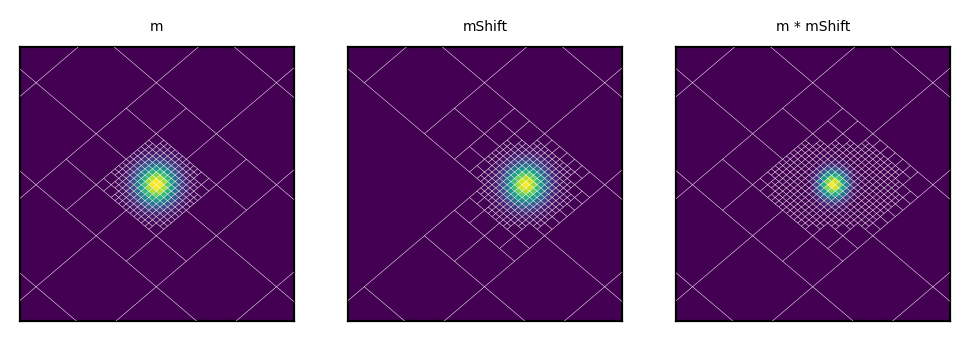

In [15]:
# Inject another shifted source in a new map
phi0 = np.deg2rad(45-.03)
disc_pix = mEq.query_disc(hmap.ang2vec(theta0, phi0), 3*sigma)

mShift = HealpixMap.moc_from_pixels(mEq.nside, disc_pix, density=True)

for pix in range(mShift.npix):
    
    theta,phi = mShift.pix2ang(pix)
    
    mShift[pix] = exp(-((theta-theta0)**2 + (phi-phi0)**2) / 2 / sigma**2)
    
#Multiply
mRes = m * mShift

# Plot side by side
fig,axes = plt.subplots(1,3, dpi=200, subplot_kw = {'projection': 'cartview', 'lonra': lonra, 'latra': latra})

axes[0].set_title("m", size= 5);
axes[1].set_title("mShift", size= 5);
axes[2].set_title("m * mShift", size= 5);

m.plot(axes[0], cbar = False);
mShift.plot(axes[1], cbar = False);
mRes.plot(axes[2], cbar = False);

# Show grid
m.plot_grid(axes[0], color='white', linewidth = .1)
mShift.plot_grid(axes[1], color='white', linewidth = .1)
mRes.plot_grid(axes[2], color='white', linewidth = .1);